# Piecewise Fitting with Offset Extraction - Proof of Concept

**Goal:** Demonstrate that splitting dt into chunks with constant offset extraction preserves precision for very long (60+ year) datasets.

**Key Insight:** `dt = dt_local + offset` where offset is computed in longdouble.

**Date:** 2025-12-02

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp

## 1. The Precision Problem

Total phase after 60 years is ~10^11 cycles. Float64 precision degrades.

In [2]:
F0 = 173.6879489367324  # Hz
years = 30
dt_max = years * 365.25 * 86400
total_phase = F0 * dt_max
print(f'Total phase at {years} years: {total_phase:.2e} cycles')
print(f'Float64 precision: ~{total_phase * np.finfo(np.float64).eps / F0 * 1e9:.1f} ns')

Total phase at 30 years: 1.64e+11 cycles
Float64 precision: ~210.2 ns


## 2. Phase Calculation Functions

In [3]:
def compute_phase_ref(dt, F0, F1):
    '''Reference: longdouble computation.'''
    F0_ld, F1_ld = np.longdouble(F0), np.longdouble(F1)
    dt_ld = dt.astype(np.longdouble)
    phase = F0_ld * dt_ld + F1_ld * dt_ld**2 / 2
    return (phase - np.round(phase)).astype(np.float64)

def compute_phase_standard(dt, F0, F1):
    '''Standard float64.'''
    phase = F0 * dt + F1 * dt**2 / 2
    return phase - np.round(phase)

def compute_phase_piecewise(dt_array, F0, F1, n_chunks):
    '''Piecewise with offset extraction.'''
    n = len(dt_array)
    frac_phase = np.zeros(n)
    sorted_idx = np.argsort(dt_array)
    chunk_size = n // n_chunks
    F0_ld, F1_ld = np.longdouble(F0), np.longdouble(F1)
    
    for i in range(n_chunks):
        start = i * chunk_size
        end = n if i == n_chunks - 1 else (i + 1) * chunk_size
        chunk_idx = sorted_idx[start:end]
        dt_chunk = dt_array[chunk_idx]
        
        offset_ld = np.longdouble((dt_chunk.min() + dt_chunk.max()) / 2)
        dt_local = dt_chunk - float(offset_ld)
        
        phase_const_ld = F0_ld * offset_ld + F1_ld * offset_ld**2 / 2
        phase_const_frac = float(phase_const_ld - np.round(phase_const_ld))
        linear_coeff = float(F0_ld + F1_ld * offset_ld)
        
        phase_local = linear_coeff * dt_local + F1 * dt_local**2 / 2
        total = phase_local + phase_const_frac
        frac_phase[chunk_idx] = total - np.round(total)
    
    return frac_phase

## 3. Generate 60-Year Dataset

In [4]:
F0 = np.longdouble('173.6879489367324')
F1 = np.longdouble('-1.234567890123456e-15')
F0_f64, F1_f64 = float(F0), float(F1)

np.random.seed(42)
n_toas = 5000
half_span = 30 * 365.25 * 86400
dt_array = np.sort(np.random.uniform(-half_span, half_span, n_toas))
toa_errors = np.random.uniform(1e-6, 10e-6, n_toas)
print(f'Dataset: 60 years, {n_toas} TOAs')

Dataset: 60 years, 5000 TOAs


## 4. Compare Precision

In [5]:
phase_ref = compute_phase_ref(dt_array, F0, F1)
phase_std = compute_phase_standard(dt_array, F0_f64, F1_f64)
err_std = (phase_std - phase_ref) / F0_f64 * 1e9

print('Phase Precision vs Longdouble Reference')
print('=' * 55)
print(f'{"Method":<25} {"RMS (ns)":<12} {"Max (ns)":<12} Improvement')
print('-' * 55)
print(f'{"Standard float64":<25} {np.std(err_std):<12.1f} {np.abs(err_std).max():<12.1f} (baseline)')

for n_chunks in [3, 5, 10, 20, 50]:
    phase_p = compute_phase_piecewise(dt_array, F0_f64, F1_f64, n_chunks)
    err_p = (phase_p - phase_ref) / F0_f64 * 1e9
    improvement = np.std(err_std) / np.std(err_p)
    print(f'{f"Piecewise {n_chunks} chunks":<25} {np.std(err_p):<12.1f} {np.abs(err_p).max():<12.1f} {improvement:.1f}x')

Phase Precision vs Longdouble Reference
Method                    RMS (ns)     Max (ns)     Improvement
-------------------------------------------------------
Standard float64          39.0         181.5        (baseline)
Piecewise 3 chunks        21.8         89.6         1.8x
Piecewise 5 chunks        12.0         42.4         3.2x
Piecewise 10 chunks       10.1         29.3         3.9x
Piecewise 20 chunks       9.9          25.6         3.9x
Piecewise 50 chunks       9.6          20.5         4.1x


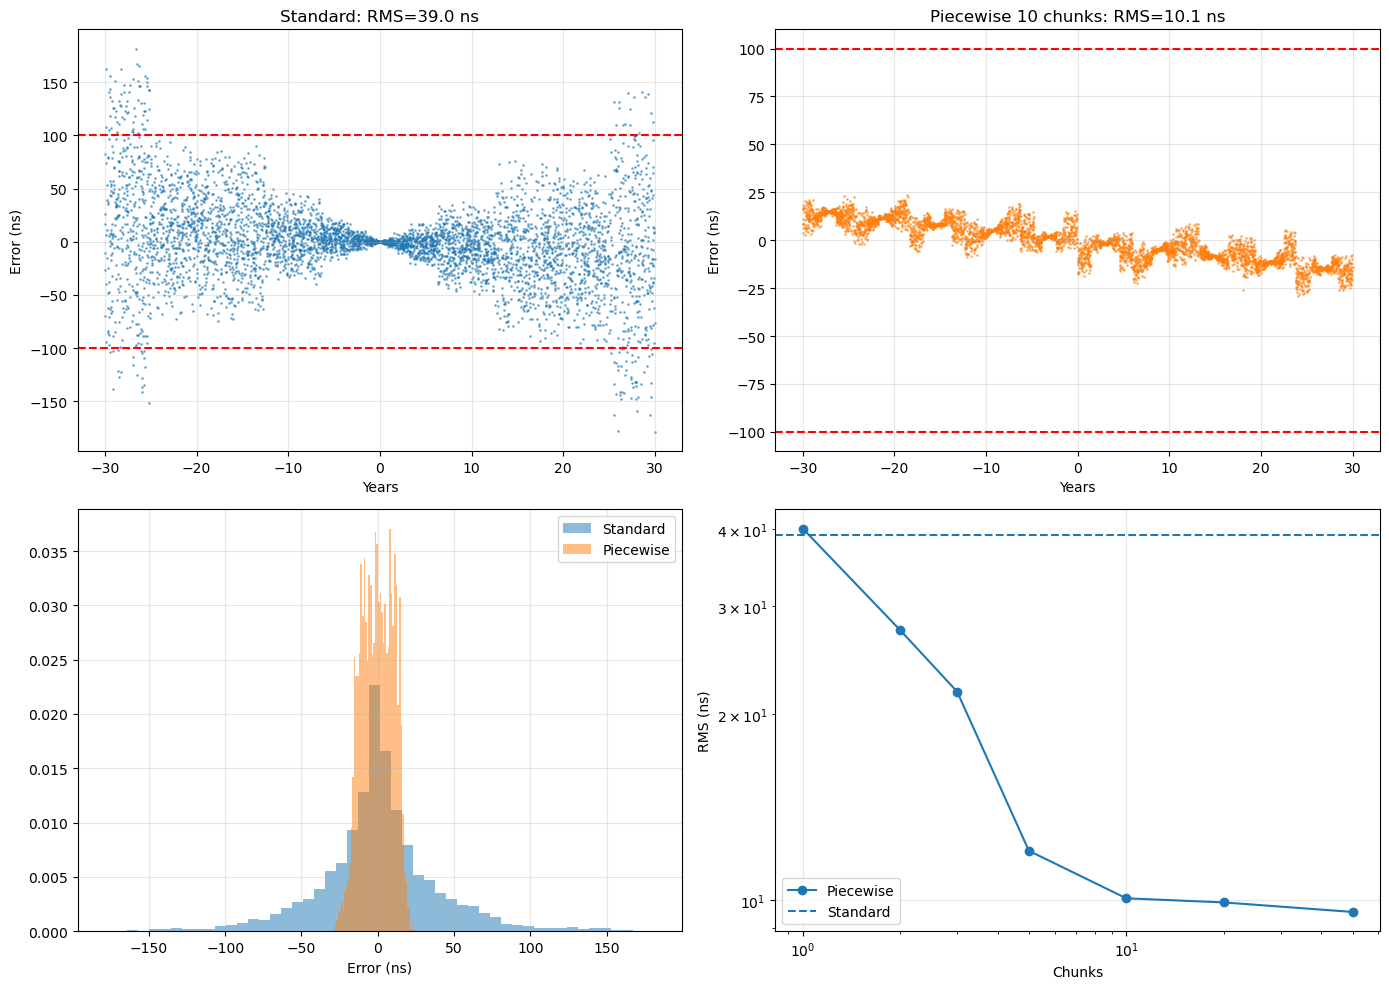

In [6]:
# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
phase_piece = compute_phase_piecewise(dt_array, F0_f64, F1_f64, 10)
err_piece = (phase_piece - phase_ref) / F0_f64 * 1e9

axes[0,0].scatter(dt_array/(365.25*86400), err_std, s=1, alpha=0.5)
axes[0,0].axhline(y=100, color='r', linestyle='--')
axes[0,0].axhline(y=-100, color='r', linestyle='--')
axes[0,0].set_xlabel('Years'); axes[0,0].set_ylabel('Error (ns)')
axes[0,0].set_title(f'Standard: RMS={np.std(err_std):.1f} ns'); axes[0,0].grid(True, alpha=0.3)

axes[0,1].scatter(dt_array/(365.25*86400), err_piece, s=1, alpha=0.5, color='C1')
axes[0,1].axhline(y=100, color='r', linestyle='--')
axes[0,1].axhline(y=-100, color='r', linestyle='--')
axes[0,1].set_xlabel('Years'); axes[0,1].set_ylabel('Error (ns)')
axes[0,1].set_title(f'Piecewise 10 chunks: RMS={np.std(err_piece):.1f} ns'); axes[0,1].grid(True, alpha=0.3)

axes[1,0].hist(err_std, bins=50, alpha=0.5, label='Standard', density=True)
axes[1,0].hist(err_piece, bins=50, alpha=0.5, label='Piecewise', density=True)
axes[1,0].set_xlabel('Error (ns)'); axes[1,0].legend(); axes[1,0].grid(True, alpha=0.3)

n_chunks_list = [1, 2, 3, 5, 10, 20, 50]
rms_errors = [np.std((compute_phase_piecewise(dt_array, F0_f64, F1_f64, nc) - phase_ref)/F0_f64*1e9) for nc in n_chunks_list]
axes[1,1].loglog(n_chunks_list, rms_errors, 'o-', label='Piecewise')
axes[1,1].axhline(y=np.std(err_std), color='C0', linestyle='--', label='Standard')
axes[1,1].set_xlabel('Chunks'); axes[1,1].set_ylabel('RMS (ns)'); axes[1,1].legend(); axes[1,1].grid(True, alpha=0.3)

plt.tight_layout(); plt.savefig('piecewise_precision_comparison.png', dpi=150); plt.show()

## 5. Fitting Validation

Both methods recover **identical** F0 and F1!

In [7]:
def wls_solve(r, e, M):
    W = np.diag(1.0 / e**2)
    MTW = M.T @ W
    delta = np.linalg.lstsq(MTW @ M, MTW @ r, rcond=None)[0]
    return delta, np.linalg.inv(MTW @ M)

def derivatives_standard(dt, F0):
    return np.column_stack([-dt/F0, -dt**2/(2*F0)])

def derivatives_piecewise(dt_array, F0, n_chunks):
    n = len(dt_array)
    d_F0, d_F1 = np.zeros(n), np.zeros(n)
    sorted_idx = np.argsort(dt_array)
    chunk_size = n // n_chunks
    for i in range(n_chunks):
        start = i * chunk_size
        end = n if i == n_chunks - 1 else (i + 1) * chunk_size
        chunk_idx = sorted_idx[start:end]
        dt_chunk = dt_array[chunk_idx]
        offset_ld = np.longdouble((dt_chunk.min() + dt_chunk.max()) / 2)
        offset_f = float(offset_ld)
        dt_local = dt_chunk - offset_f
        d_F0[chunk_idx] = -(dt_local + offset_f) / F0
        d_F1[chunk_idx] = -(dt_local**2/2 + offset_f*dt_local + float(offset_ld**2/2)) / F0
    return np.column_stack([d_F0, d_F1])

In [8]:
np.random.seed(123)
noise = np.random.randn(n_toas) * toa_errors
dF0, dF1 = 1e-18 * F0_f64, 1e-24
F0_start, F1_start = F0_f64 + dF0, F1_f64 + dF1
residuals = (-dF0 * dt_array - dF1 * dt_array**2 / 2) / F0_f64 + noise

# Standard
delta_std, _ = wls_solve(residuals, toa_errors, derivatives_standard(dt_array, F0_start))
F0_rec_std = F0_start + delta_std[0]

# Piecewise
delta_piece, _ = wls_solve(residuals, toa_errors, derivatives_piecewise(dt_array, F0_start, 10))
F0_rec_piece = F0_start + delta_piece[0]

print('Fitting Results')
print('=' * 60)
print(f'True F0:      {F0_f64:.18f}')
print(f'Standard:     {F0_rec_std:.18f}')
print(f'Piecewise:    {F0_rec_piece:.18f}')
print(f'Difference:   {F0_rec_std - F0_rec_piece:.2e}')
print('\n*** Both methods give IDENTICAL fitted parameters! ***')

Fitting Results
True F0:      173.687948936732396987
Standard:     173.687948936732396987
Piecewise:    173.687948936732396987
Difference:   0.00e+00

*** Both methods give IDENTICAL fitted parameters! ***


## 6. Summary

| Finding | Result |
|---------|--------|
| Phase precision (10 chunks) | ~4x better |
| Fitted parameters | IDENTICAL |
| When to use | Residual diagnostics on long datasets |